# Made Easy - How to Make Sense of Weight Decay
-----------

Weight decay, aka L2 regularization, aka ridge regression... why does it have so many names? Your guess is as good as mine. Like many other deep learning concepts, it's a fancy term for a simple concept (in practice). It's also something which took me a very long time to really understand, because it was cluttered behind all this math. If you're having the same struggle I was having, then I'm hoping this article ends your search.

## What is it?

Let's start off with what weight decay is. Weight decay is a regularization technique (another fancy term). What does that mean? It basically means that it helps our machine learning model to not overfit (overfitting is explained below).

## How does it work?

The above is all good and well, but how does it work? It works by adding the squared sum of our weights (multiplied by a hyperparameter) to our loss function.

The above sounds a little complicated, so let's go through it in code.

## How does it work (in code)?

As always, let's start off by importing the required libraries.

In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.model_selection import train_test_split

Now that we have that out of the way, let's get some data. For the purposes of this article, we can get away with making our own data using PyTorch's randn function.

We'll create a tensor having the shape 1000x1000 for the features (X) using PyTorch's randn function. Along with that, we'll also create our target tensor (y). The target tensor will be binary (i.e., only 2 values). To accomplish that, we'll set half the tensor to 0 and the other half to 1. 

In [ ]:
dim = 1000
X = torch.randn((dim,dim), dtype=float)
y = torch.cat((torch.zeros(dim//2, dtype=float), torch.ones(dim//2, dtype=float)))

Let's use sklearn's train_test_split function to shuffle our data and split into a train and test set. We'll allocate 33% of the data for testing and the other 66% of it for training.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Now that we have that out of the way, let's create a simple model. It will consist of only 1 hidden layer. The hidden layer will be half the size of the input layer (i.e., 500). We'll also use the sigmoid function as our activation function for the hidden layer and the last layer.

In [ ]:
class Model(nn.Module):

    def __init__(self, dim):
        super().__init__()
        self.hidden_layer = nn.Linear(dim, dim//2)
        self.last_layer = nn.Linear(dim//2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        out = self.sigmoid(self.hidden_layer(X))
        out = self.sigmoid(self.last_layer(out))
        return out

We're almost ready to train our model. Let's instantiate our Model class, set our loss to BCELoss (because our target is binary) and set our optimizer to SGD. We'll train for 1000 epochs at a learning rate of 1e-1.

In [ ]:
model = Model(dim)
bce = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1)
epochs = 1000

Let's train our model! While training, we'll print out our loss (i.e., BCE) at every 100 epochs, allowing us to have an insight on our model's performance during training.

In [ ]:
train_loss = []
test_loss = []

for epoch in range(epochs+1):
    model.train()
    y_pred = model(X_train.float())
    loss = bce(y_pred, y_train.reshape(-1,1).float())
    train_loss.append(loss.sum())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if(epoch % 100 == 0):
        print('Train: epoch: {0} - loss: {1:.5f}'.format(epoch, train_loss[-1]))
  
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test.float())
        loss = bce(y_pred, y_test.reshape(-1,1).float())
        test_loss.append(loss)

        if(epoch % 100 == 0):
            print('Test: epoch: {0} - loss: {1:.5f}'.format(epoch, test_loss[-1]))

Train: epoch: 0 - loss: 0.69640
Test: epoch: 0 - loss: 0.70919
Train: epoch: 100 - loss: 1.11392
Test: epoch: 100 - loss: 1.35615
Train: epoch: 200 - loss: 0.20923
Test: epoch: 200 - loss: 0.91265
Train: epoch: 300 - loss: 0.10423
Test: epoch: 300 - loss: 1.15172
Train: epoch: 400 - loss: 0.05922
Test: epoch: 400 - loss: 1.36622
Train: epoch: 500 - loss: 0.03818
Test: epoch: 500 - loss: 1.53844
Train: epoch: 600 - loss: 0.02698
Test: epoch: 600 - loss: 1.67684
Train: epoch: 700 - loss: 0.02034
Test: epoch: 700 - loss: 1.79067
Train: epoch: 800 - loss: 0.01605
Test: epoch: 800 - loss: 1.88655
Train: epoch: 900 - loss: 0.01311
Test: epoch: 900 - loss: 1.96896
Train: epoch: 1000 - loss: 0.01099
Test: epoch: 1000 - loss: 2.04100


Interesting... Plotting my training and test loss always helps me to better visualize it, so let's use matplotlib to do that.

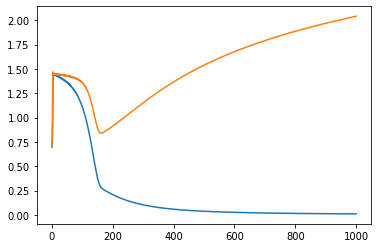

In [ ]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.show()

That's unfortunate. Our model is clearly overfitting (i.e., as our loss on our training set goes down, our loss on our test set actually gets worse).

So how do we stop our model from overfitting? One solution would be to get more data, but unfortunately, that's not always possible. Even if it is possible, it may not be that easy to get a hold of the extra data. What now? Well, we can always use weight decay.

If you remember from above, I mentioned that weight decay is when we add the squared sum of our weights (multiplied by a hyperparameter) to our loss function.

I'm going to let you look at the slide below, which a stole from Andrew Ng's deep learning course, and hopefully you get it.

<img src="images/l2%20screenshot.png?raw=true"  width="1000" height="1000">

Yeah... that doesn't really help. If you're anything like me, then slides like the 1 above are probably the reason why you've been struggling with weight decay this entire time.

If you take a closer look at the slide, you'll see that I circled 2 equations. The equation circled in violet is the actual equation for weight decay, and the equation circled in red is the equation used during backpropagation to update the weights.

We're going to throw away the actual equation (circled in violet) and put all our attention towards the equation used in backpropagation, specifically, this portion of the equation.

<img src="images/l2%20backprop.PNG?raw=true"  width="500" height="500">

If you haven't realized yet, the equation above is the exact same equation used for the original backpropagation (without weight decay), except it has the weights multiplied by a fraction (λ (i.e., lambda) divided by the number of rows) tacked on at the end.

Keeping the above in mind, we're going to do some simple math here. We're going to state the following:

wd = λ/m

Now that we did that, we're going to put a restriction on wd saying that wd must be a value between 0 and 1. If wd is a value between 0 and 1, then any value that it multiplies with will make that value smaller. In other words, it will decay it. Replacing λ/m with wd, our new equation looks like the following:

(equation from backpropagation) + wd*w

I want you to ask yourself a question here; what is wd multiplying with? It's multiplying with w. And what does w represent? It represents the weights. I'm hoping something clicked there in your mind. If wd decays anything it multiplies with and the thing it's multiplying with are the weights, then it's decaying the weights... weight decay!

Finally, it makes sense! But how do we do that in PyTorch?

Let's do a few things before we answer that question. We're going to reinstantiate our model, loss and optimizer. We'll also add an extra variable by the name of weight_decay and set that to 1e-1.

In [ ]:
model = Model(dim)
bce = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1)
weight_decay = 1e-1

Now that we got that out of the way, how do we access the backpropagation equation to adjust it for weight decay. If you recall, the backpropagation equation is also known as the gradient and the gradient is set on the weights (with requires_grad=True). So how do we access that? If you take a look at the code cell above, you'll see that we're passing the model parameters to the SGD optimizer. Those parameters are our weights (and our bias). To access the gradients of those weights, all we have to do is call ".grad" on them. Once we get a hold of those, we can just add our weight decay equation to the end of it.

Let's see how we can do it in code. Let's train our model with weight decay.

Note: the equation for weight decay is a little different for the Adam optimizer, but it follows the same principle as SGD.

In [ ]:
train_loss = []
test_loss = []

for epoch in range(epochs+1):
    model.train()
    y_pred = model(X_train.float())
    loss = bce(y_pred, y_train.reshape(-1,1).float())
    train_loss.append(loss.sum())

    optimizer.zero_grad()
    loss.backward()
    for w in model.parameters():
        w.grad.add_(w, alpha=weight_decay) # synonymous to: w.grad += w*weight_decay
    optimizer.step()

    if(epoch % 100 == 0):
        print('Train: epoch: {0} - loss: {1:.5f}'.format(epoch, train_loss[-1]))
  
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test.float())
        loss = bce(y_pred, y_test.reshape(-1,1).float())
        test_loss.append(loss)

        if(epoch % 100 == 0):
            print('Test: epoch: {0} - loss: {1:.5f}'.format(epoch, test_loss[-1]))

Train: epoch: 0 - loss: 0.69296
Test: epoch: 0 - loss: 0.69721
Train: epoch: 100 - loss: 1.37870
Test: epoch: 100 - loss: 1.43117
Train: epoch: 200 - loss: 1.28452
Test: epoch: 200 - loss: 1.41049
Train: epoch: 300 - loss: 1.10652
Test: epoch: 300 - loss: 1.36360
Train: epoch: 400 - loss: 0.88044
Test: epoch: 400 - loss: 1.26943
Train: epoch: 500 - loss: 0.76552
Test: epoch: 500 - loss: 1.21283
Train: epoch: 600 - loss: 0.73315
Test: epoch: 600 - loss: 1.19893
Train: epoch: 700 - loss: 0.72321
Test: epoch: 700 - loss: 1.19543
Train: epoch: 800 - loss: 0.71966
Test: epoch: 800 - loss: 1.19431
Train: epoch: 900 - loss: 0.71829
Test: epoch: 900 - loss: 1.19389
Train: epoch: 1000 - loss: 0.71773
Test: epoch: 1000 - loss: 1.19371


As you can see, we iterate over the parameters (i.e., the weights and bias), get the equation of backpropagation from it (i.e., w.grad) and add weight_day*w to it. That's it! That's weight decay!

Let's plot our results.

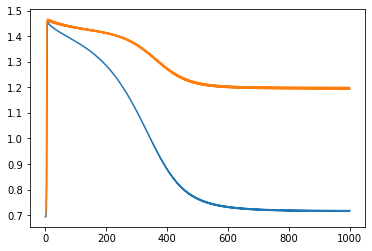

In [ ]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.show()

As you can see from our plot, the model is no longer overfitting our training set.

## PyTorch's built-in weight decay

Thanks to the team at PyTorch, the optimizers already come with the built-in functionality of weight decay. All we have to do is set it when making our optimizer, such as I've done below.

In [ ]:
model = Model(dim)
bce = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1, weight_decay=1e-1)

Let's train our model again, but this time using PyTorch's built-in weight decay.

In [ ]:
train_loss = []
test_loss = []

for epoch in range(epochs+1):
    model.train()
    y_pred = model(X_train.float())
    loss = bce(y_pred, y_train.reshape(-1,1).float())
    train_loss.append(loss.sum())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if(epoch % 100 == 0):
        print('Train: epoch: {0} - loss: {1:.5f}'.format(epoch, train_loss[-1]))
  
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test.float())
        loss = bce(y_pred, y_test.reshape(-1,1).float())
        test_loss.append(loss)

        if(epoch % 100 == 0):
            print('Test: epoch: {0} - loss: {1:.5f}'.format(epoch, test_loss[-1]))

Train: epoch: 0 - loss: 0.70713
Test: epoch: 0 - loss: 0.75445
Train: epoch: 100 - loss: 1.38277
Test: epoch: 100 - loss: 1.43209
Train: epoch: 200 - loss: 1.29256
Test: epoch: 200 - loss: 1.41250
Train: epoch: 300 - loss: 1.12141
Test: epoch: 300 - loss: 1.36892
Train: epoch: 400 - loss: 0.89357
Test: epoch: 400 - loss: 1.27613
Train: epoch: 500 - loss: 0.76997
Test: epoch: 500 - loss: 1.21521
Train: epoch: 600 - loss: 0.73462
Test: epoch: 600 - loss: 1.19976
Train: epoch: 700 - loss: 0.72389
Test: epoch: 700 - loss: 1.19591
Train: epoch: 800 - loss: 0.72007
Test: epoch: 800 - loss: 1.19468
Train: epoch: 900 - loss: 0.71860
Test: epoch: 900 - loss: 1.19422
Train: epoch: 1000 - loss: 0.71800
Test: epoch: 1000 - loss: 1.19403


Let's plot our graph for a clearer picture.

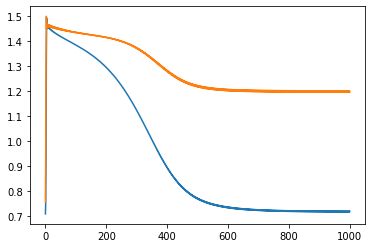

In [ ]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.show()

Awesome! As expected, it works the exact same way as the weight decay we coded ourselves!

## What values should I use?

Weight decay is a hyperparameter which you will need to tune for your own specific case. As we said above, it needs to be a value between 0 and 1. Generally, in practice, the values of 1 to the power of negative values are often used (e.g., 1e-1, 1e-2, etc.).

And that's the end of weight decay. Hope the article helped clear up any confusions you may have had.